In [1]:
import scanpy as sc
import scvelo as scv
import numpy as np
import pandas as pd
import anndata
import seaborn as sns
import matplotlib.pyplot as plt

from PerturbSeq_CMV.paths import DATA_DIR

In [2]:
folder = DATA_DIR / "rawdata" / "CRISPRi_perturb_host_processed" 

In [3]:
adata_genesxcells = sc.read_mtx(folder / "matrix.mtx")

Transpose gene x cell to cell x gene 

In [4]:
adata_genesxcells

AnnData object with n_obs × n_vars = 34057 × 46364

In [5]:
adata = anndata.AnnData(adata_genesxcells.X.T)
adata.X.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [6]:
adata

AnnData object with n_obs × n_vars = 46364 × 34057

**Read the metadata** 

In [7]:
barcode_path = folder / "barcodes.tsv"
cellidentity_path = folder / "cell_identities.csv"
genes_path = folder /"genes.tsv"

In [8]:
barcodes = pd.read_csv(barcode_path, sep="\t", header=None)
cellidentity = pd.read_csv(cellidentity_path)
genes = pd.read_csv(genes_path, sep="\t", header=None)
genes.columns = ["ENSMBL", "gene ID"]

Load the comprehensive metadata from the supplementary material of the paper

In [9]:
metadata = pd.read_excel(folder / "CRISPRi_perturb_host_processed.xlsx")
metadata.head()

,cell_barcode,gem_group,UMI_count,guide_UMI_count,guide_read_count,guide_coverage,experimental_time,guide_identity,guide_target,guide_phenotype,guide_rank,cell_cycle_phase,viral_load,interferon_score,cluster,UMAP_1,UMAP_2
0,AAACCTGAGATAGTCA-1,1,12921,74,960,12.972973,00h,LAMTOR4_pMH2084,LAMTOR4,protective,1,S,0.000000,-1.009502,naive,0.091906,-3.691660
1,AAACCTGAGATGAGAG-1,1,12680,76,887,11.671053,00h,C17orf59_pMH2042,C17orf59,protective,2,G2-M,0.000079,-1.078387,naive,-1.336865,-4.274636
2,AAACCTGAGCGGCTTC-1,1,4335,14,199,14.214286,00h,CYCS_pMH2180,CYCS,protective,1,G1-S,0.000000,-1.445303,naive,3.524614,-5.250340
3,AAACCTGCAAAGTCAA-1,1,4837,17,225,13.235294,00h,TRAPPC11_pMH2060,TRAPPC11,protective,1,G2-M,0.000000,-1.106561,naive,-3.325677,-4.142260
4,AAACCTGCAAGAAGAG-1,1,8022,77,937,12.168831,00h,STAT2_pMH2128,STAT2,sensitizing,1,G2-M,0.000125,-1.144769,naive,-1.912844,-3.924798


**Information we have:** UMI_count, guide_UMI_count, time, guide identity, guide_target, guide_phenotype, interferon score 

Subset the cells based on the metadata file 

In [10]:
cells_to_keep = barcodes.loc[barcodes.isin(np.array(metadata.cell_barcode))[0]]
# Get indexes
cells_to_keep_idx = np.array(cells_to_keep.index)

In [11]:
adata = adata[cells_to_keep_idx,:]

Experimental time 

In [12]:
metadata.experimental_time = [float(time.split("h")[0]) for time in metadata.experimental_time]

In [13]:
np.unique(metadata.experimental_time)

array([ 0., 24., 48., 72.])

In [14]:
adata.obs = metadata

Fix the vars

In [15]:
adata.var = pd.DataFrame(genes)
adata.var.index = adata.var["gene ID"]

In [16]:
adata.var["mt"] = adata.var_names.str.startswith("MT-") 

**Examine metadata**

In [17]:
print(f"Number of targets {len(np.unique(metadata.guide_target))}")

Number of targets 54


In [18]:
np.unique(metadata.guide_target)

array(['AMFR', 'ASNA1', 'B4GALT7', 'BAG6', 'BCL2L1', 'C17orf59', 'CASP2',
       'CASP3', 'CASP9', 'COG2', 'COG5', 'COG8', 'CSNK2A1', 'CUL3',
       'CYCS', 'DCAF4', 'DDA1', 'EXT2', 'FAM126A', 'GFP', 'GLCE', 'HCCS',
       'HS6ST1', 'IFNAR2', 'IRF9', 'KIAA1432', 'KIRREL', 'KXD1',
       'LAMTOR1', 'LAMTOR2', 'LAMTOR3', 'LAMTOR4', 'LAMTOR5', 'LARGE',
       'NAE1', 'NEDD8', 'RAB6A', 'RBBP5', 'RBX1', 'RGP1', 'SEC61B',
       'SEC62', 'SEC63', 'SLC35B2', 'STAT2', 'TRAF2', 'TRAPPC11',
       'TRAPPC12', 'TRAPPC8', 'UBA3', 'UNC50', 'VTCN1', 'WDR26', 'WDR81'],
      dtype=object)

From paper method: GFP is control!!

In [19]:
np.unique(metadata.guide_phenotype)

array(['control', 'protective', 'sensitizing'], dtype=object)

In [20]:
highly_expressed_genes = np.array((adata.X.todense().sum(0)>10000).astype(np.bool)).squeeze(0)
print(f"Number of genes with more than 10k counts: {np.sum(highly_expressed_genes)}")

Number of genes with more than 10k counts: 4705


Use highly expressed genes as highly_variable key

In [21]:
adata.var["highly_variable"] = highly_expressed_genes

Normalize as explained in the paper

In [22]:
sc.pp.normalize_total(adata, np.mean(adata.X.sum(1)))

PCA and UMAP

In [23]:
# PCA
sc.tl.pca(adata, svd_solver="arpack", use_highly_variable=True)

In [24]:
sc.pp.neighbors(adata, n_pcs=40)

In [25]:
sc.tl.umap(adata)

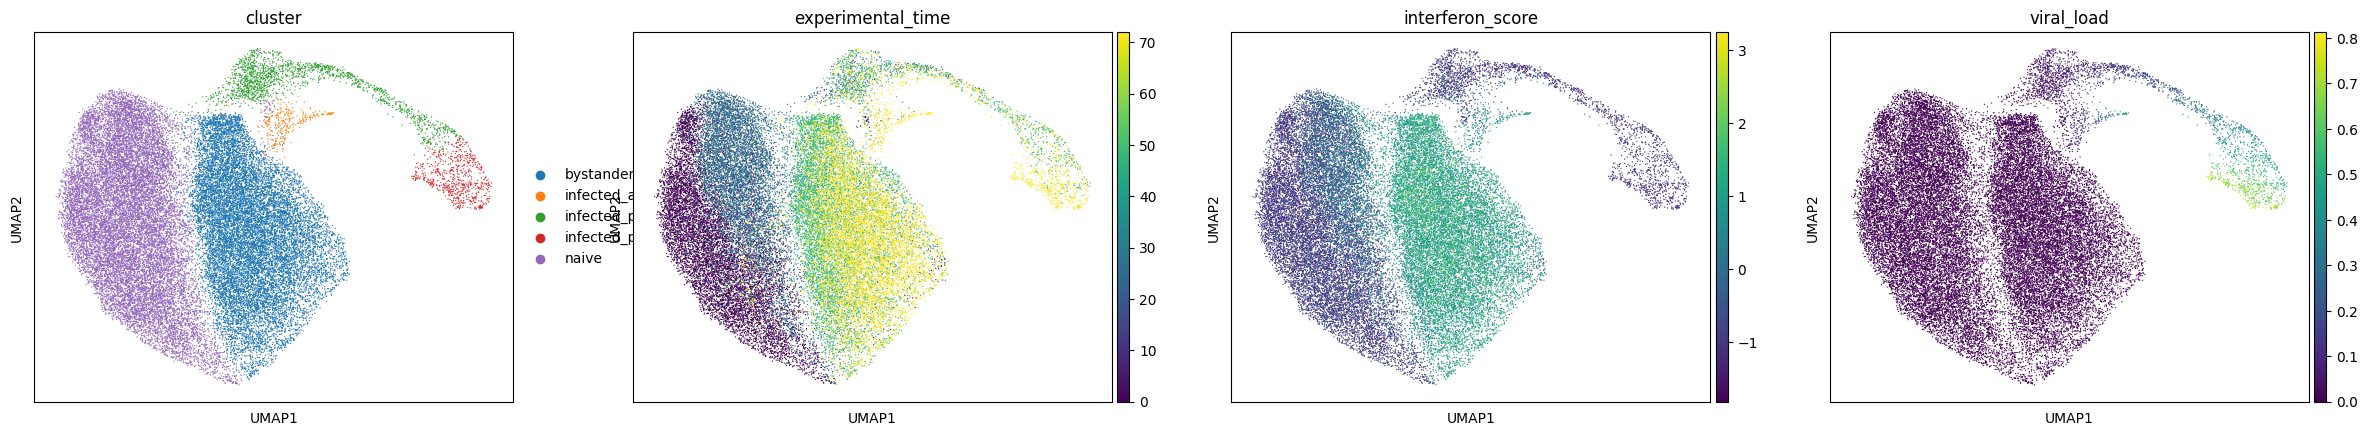

In [26]:
sc.pl.umap(adata, color=["cluster", "experimental_time", "interferon_score", "viral_load"])

**Save the anndata**

In [27]:
processed_data_dir = DATA_DIR / "processed"

In [29]:
adata.write(processed_data_dir / "perturb_seq_host_factors.h5ad")